<h2>
    <u>Phase Retrieval from Spectral Interferometry Spectral Data</u>
</h2>

This file performs the delta phi retrieval for given spectral data. You need to provide three files:

1. Reference arm spectrum,
2. Fibre arm spectrum,
3. Spectral intereference (combined).

You may need to adjust the arguments in the DeltaPhiRetrievalProcedure. 
It is assumed you are working in wavelengths, nm, but you can adjust the code as needed.

Load necessary packages**:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Functions as f
sif = f.SI_Functions_Lambda()
sifomega = f.SI_Functions_Omega()
from RefractiveIndexClass import RefractiveIndex as RI

** Note, the Functions class is custom built and needs to be in your working repository. Find them on [Github](https://github.com/jmorse2020/Physics-FYP).

Add your data files here:

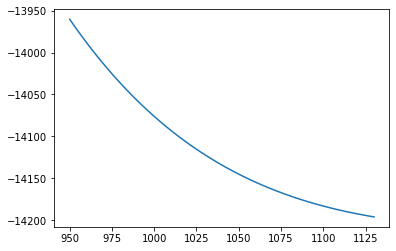

In [2]:
def m2nm(x):
    return x * 1e9

wavelengths = np.linspace(950, 1130, 10000) # [nm]
ZDW = 1280                          # Zero delay wavelngth [nm]
delta = ZDW / 4                     # phase shift
central_wavelength = 1040           # [nm]
sigma = 20                          # Bandwidth
L_f = 0.2                           # Fibre length [m]
L_f = m2nm(L_f)                     # Fibre length [nm]
L_air = - L_f * RI.n_group(RI.n_fs, ZDW) + delta                               # Required air difference for ZDW

# Interfernce
deltaPhi = 2 * np.pi / wavelengths * (L_air  + L_f * RI.n_fs(wavelengths))     # Spectral phase difference
plt.plot(wavelengths, deltaPhi)
wavelengths_sim = wavelengths
spectral_phase_sim = 1 + np.cos(deltaPhi)

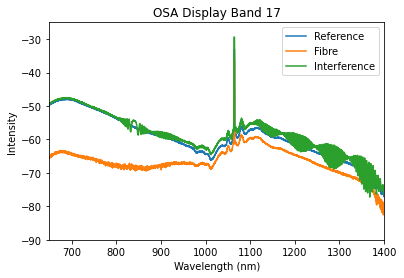

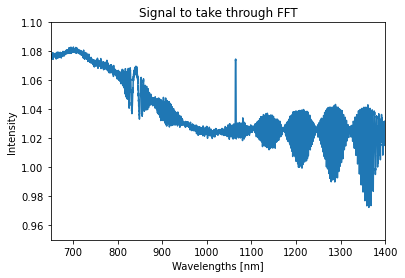

In [3]:
# Add your paths ...
reference_arm_data_file_path =  "Data Files/21-Nov-2023-data/no-poi-reference-arm-550-1700nm-1.CSV" #"Sample-Data-1/b6_ref.CSV"
fibre_arm_data_file_path =  "Data Files/21-Nov-2023-data/no-poi-fibre-arm-550-1700nm-1.CSV" #"Sample-Data-1/b6_signal.CSV"
spectral_interference_data_file_path =  "Data Files/21-Nov-2023-data/no-poi-spectral-interference-550-1700nm-1.CSV" #"Sample-Data-1/b6_fringes.CSV"

# Provide information about your data (it is assummed consistent across files):
skip_rows = 40
header = None
is_log = True
wavelength_col_index = 0
intensity_header_name = 0

def LogConversion(y):
    return 10**(y)

# Data will be read
reference_data = pd.read_csv(reference_arm_data_file_path, header = header, skiprows = skip_rows)
wavelengths = reference_data[0]
reference_arm_intensity = reference_data[1]
fibre_data = pd.read_csv(fibre_arm_data_file_path, header = header, skiprows = skip_rows)
fibre_arm_intensity = fibre_data[1]
spectral_interference_data = pd.read_csv(spectral_interference_data_file_path, header = header, skiprows = skip_rows)
spectral_interference_intensity = spectral_interference_data[1]

plt.plot(wavelengths, reference_arm_intensity, label = "Reference")
plt.plot(wavelengths, fibre_arm_intensity, label = "Fibre")
plt.plot(wavelengths, spectral_interference_intensity, label = "Interference")
plt.xlim([650,1400])
plt.ylim([-90,-25])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.title("OSA Display Band 17")
plt.legend()
plt.show()

if is_log:
    for data in [reference_arm_intensity, fibre_arm_intensity, spectral_interference_intensity]:
        data = LogConversion(data)

# Convert and extract the phase by dividing by the other arms...
# Note - change name from spectral_phase to something else
spectral_phase =  ((spectral_interference_intensity - reference_arm_intensity - fibre_arm_intensity) + np.sqrt(reference_arm_intensity * fibre_arm_intensity)) / (2 * np.sqrt(reference_arm_intensity * fibre_arm_intensity))
plt.plot(wavelengths, spectral_phase, label="Extracted spectral phase")
plt.xlim([650,1400])
plt.ylim([0.95,1.1])
plt.title("Signal to take through FFT")
plt.xlabel("Wavelengths [nm]")
plt.ylabel("Intensity")
plt.show()


Shift amount:  751


/Users/jackmorse/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/jackmorse/Documents/University/Year 4/Semester 1/FYP/Physics-FYP/Functions.py:118: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 2)
/Users/jackmorse/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


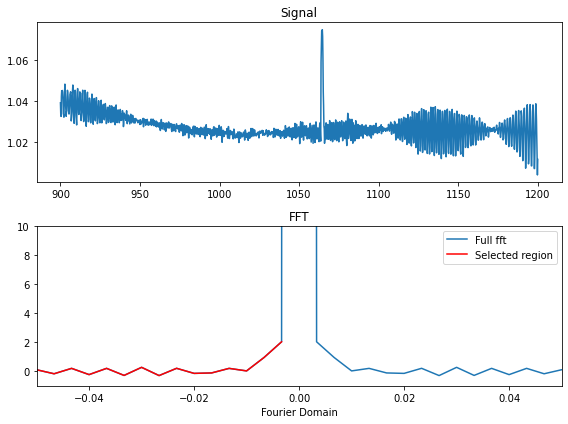

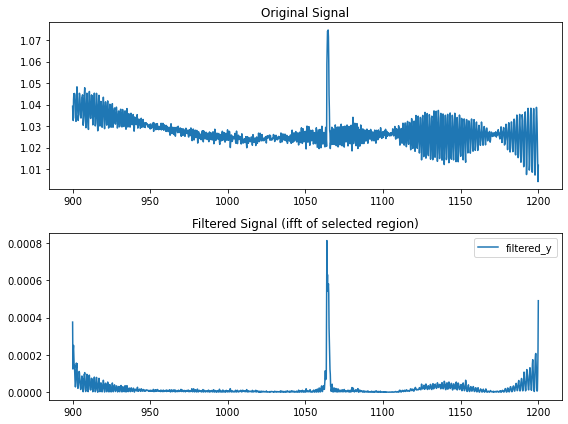

[   1.26220414    1.28513345    1.39942313 ... -518.72367813 -519.04551679
 -519.5712839 ]
MIN:  -520.8249857619873
MAX:  1.4490937836291649
Final ys:
[   1.26220414    1.28513345    1.39942313 ... -518.72367813 -519.04551679
 -519.5712839 ]


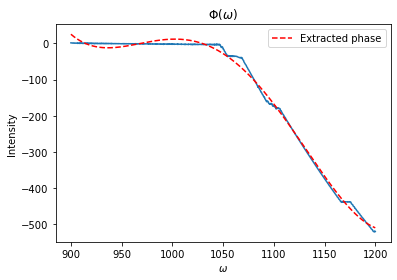

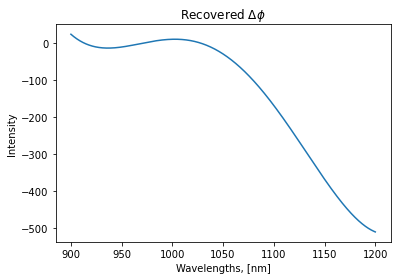

In [4]:
# You can filter the spectral phase data, e.g. if it baloons near edges or contains a point of inflection you wish to remove ...
min_spectral_phase_wavelength = 900
max_spectral_phase_wavelength = 1200
if min_spectral_phase_wavelength != None and max_spectral_phase_wavelength != None:
    indices = np.where((wavelengths >= min_spectral_phase_wavelength) & (wavelengths <= max_spectral_phase_wavelength))[0]
    wavelengths = wavelengths[indices]
    spectral_phase = spectral_phase[indices]  

# You may have to manually adjust parameters. The main ones are keep_min_freq and fft_xlim.
coefficients = sif.DeltaPhiRetrievalProcedure(x=wavelengths, y=spectral_phase, order = 4, keep_min_freq = 0.002, keep_max_freq = -1, side = "left", show_plots = True, fft_x_lim = [-0.05, 0.05], fft_y_lim=[-1,10], hanning = False, normalise=False)[1]
phi = lambda var: np.poly1d(coefficients)(var)
plt.plot(wavelengths, phi(wavelengths))
plt.title("Recovered $\Delta \phi$")
plt.xlabel("Wavelengths, [nm]")
plt.ylabel("Intensity") # Think about the units, might be in rad something.
plt.show()

Here's what the extracted refractive index looks like:

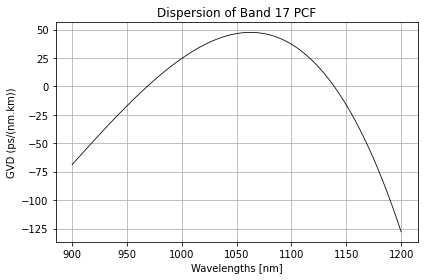

In [21]:
beta = sif.ObtainBetaFromPhi(phi, 0.575)
GVD = sif.Big_D(beta)

# n_eff = sif.Obtain_n(beta)

#plt.plot(wavelengths, np.array(GVD(wavelengths))*1e28)
plt.plot(wavelengths, 1e15*np.array(GVD(wavelengths)), color='k', linewidth=0.8)
plt.title("Dispersion of Band 17 PCF")
# plt.plot(converted_wavelengths, np.zeros(len(converted_wavelengths)), color='r', linestyle='--')
plt.ylabel("GVD (ps/(nm.km))")
plt.xlabel("Wavelengths [nm]")
plt.grid()
plt.tight_layout()
from DataAnalysisClass import DataHandling as DH
DH.write_csv(file_path="/Users/jackmorse/Desktop/FFT-GVD-data.csv", data=[wavelengths,  1e15*np.array(GVD(wavelengths))], preamble='')
plt.savefig("/Users/jackmorse/Desktop/GVD-Band-17.png", dpi=1200)


# Using new functions defined in omega

Shift amount:  751


/Users/jackmorse/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/jackmorse/Documents/University/Year 4/Semester 1/FYP/Physics-FYP/Functions.py:118: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 2)
/Users/jackmorse/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


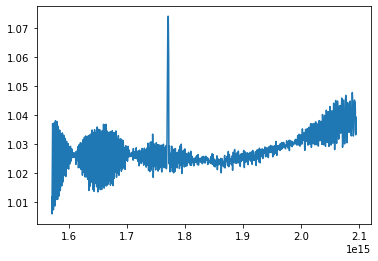

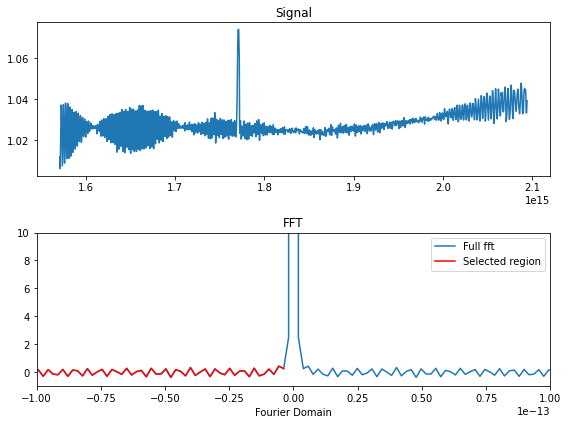

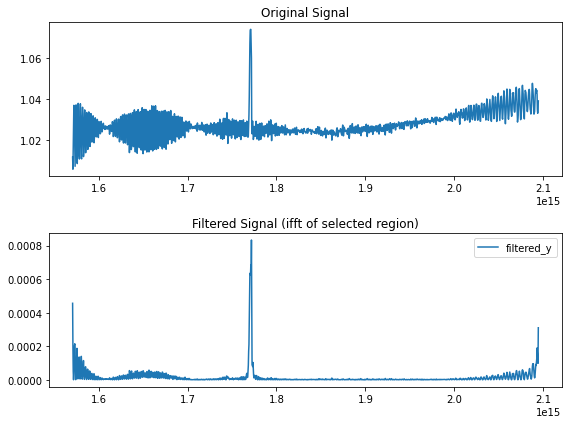

[  -2.04305211   -2.6748535    -3.00253688 ... -592.10634645 -591.99220481
 -591.96033675]
MIN:  -592.1063464490873
MAX:  -1.0988840944071834
Final ys:
[  -2.04305211   -2.6748535    -3.00253688 ... -592.10634645 -591.99220481
 -591.96033675]


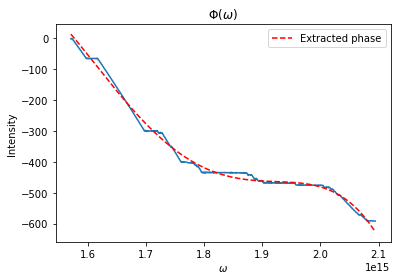

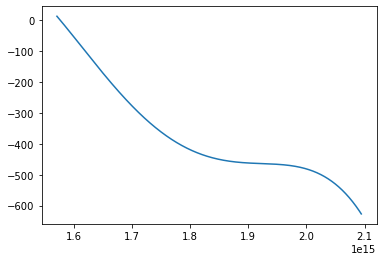

In [6]:
[omegas, intensity] = sifomega.ConvertWavelengthSpectraToOmega(wavelengths, spectral_phase)
plt.plot(omegas,intensity)
coefficients_omega = sif.DeltaPhiRetrievalProcedure(x=omegas, y=intensity, order = 4, keep_min_freq = 0.025e-13, keep_max_freq = -1, side = "left", show_plots = True, fft_x_lim = [-1e-13, 1e-13], fft_y_lim=[-1, 10], hanning = False, normalise=False)[1]
phi_omega = lambda var: np.poly1d(coefficients_omega)(var)
plt.plot(omegas, phi_omega(omegas))

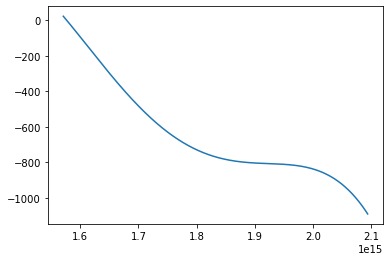

In [7]:
beta_omega = sifomega.ObtainBetaFromPhi(phi_omega,0.575)
plt.plot(omegas,beta_omega(omegas))

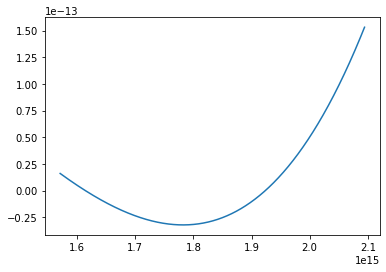

In [8]:
GVD_omega = sifomega.Big_D(beta_omega)
plt.plot(omegas,GVD_omega(omegas))

Text(0.5, 1.0, 'GVD obtained from FFT method')

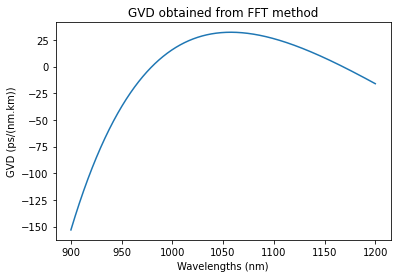

In [9]:
[converted_wavelengths, wavelength_intensity_GVD] = sifomega.ConvertOmegaSpectraToWavelength(omegas, GVD_omega(omegas))
plt.plot(converted_wavelengths, -1*wavelength_intensity_GVD*1e15) #Check this conversion factor
plt.ylabel("GVD (ps/(nm.km))")
plt.xlabel("Wavelengths (nm)")
plt.title("GVD obtained from FFT method")

# Using CDA rather than fitting polynomial

In [10]:
def central_difference_derivative(x, y):
    n = len(x)
    h = x[1] - x[0]

    derivative = np.zeros_like(y, dtype=float)

    # Central difference approximation for interior points
    for i in range(1, n - 1):
        derivative[i] = (y[i + 1] - y[i - 1]) / (2 * h)

    # Forward and backward difference for the endpoints
    derivative[0] = (y[1] - y[0]) / h
    derivative[-1] = (y[-1] - y[-2]) / h

    return derivative

def second_order_cda(x, y):
    n = len(x)
    dx = x[1] - x[0]

    second_derivative = np.zeros_like(y, dtype=float)

    # Second-order central difference approximation for interior points
    for i in range(1, n - 1):
        second_derivative[i] = (y[i + 1] - 2 * y[i] + y[i - 1]) / (dx ** 2)

    # Forward and backward difference for the endpoints
    second_derivative[0] = (y[2] - 2 * y[1] + y[0]) / (dx ** 2)
    second_derivative[-1] = (y[-1] - 2 * y[-2] + y[-3]) / (dx ** 2)

    return second_derivative

Shift amount:  751


/Users/jackmorse/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/jackmorse/Documents/University/Year 4/Semester 1/FYP/Physics-FYP/Functions.py:118: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 2)
/Users/jackmorse/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


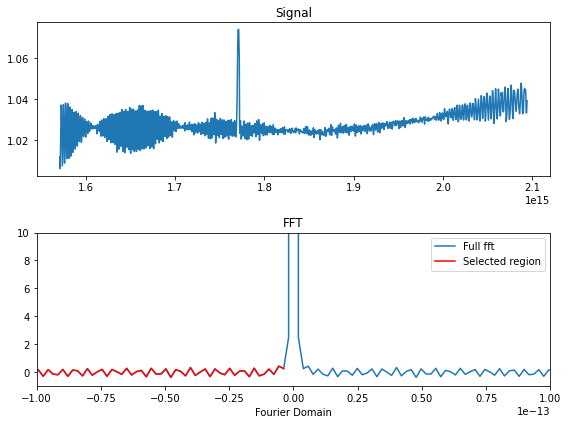

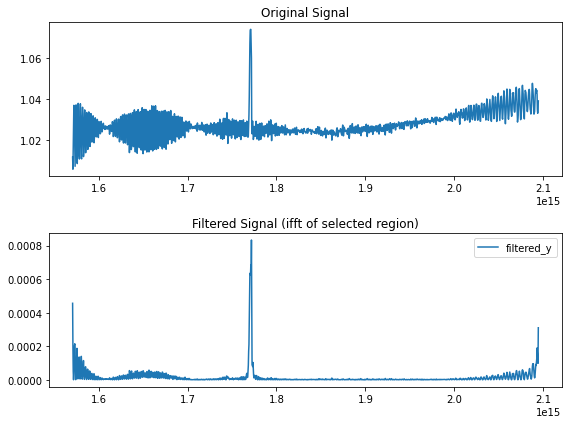

[  -2.04305211   -2.6748535    -3.00253688 ... -592.10634645 -591.99220481
 -591.96033675]
MIN:  -592.1063464490873
MAX:  -1.0988840944071834
Final ys:
[  -2.04305211   -2.6748535    -3.00253688 ... -592.10634645 -591.99220481
 -591.96033675]


<ipython-input-11-14cc299035e0>:1: RankWarning: Polyfit may be poorly conditioned
  phase = sif.DeltaPhiRetrievalProcedure(x=omegas, y=intensity, order = 9, keep_min_freq = 0.025e-13, keep_max_freq = -1, side = "left", show_plots = True, fft_x_lim = [-1e-13, 1e-13], fft_y_lim=[-1, 10], hanning = False, normalise=False)[0]


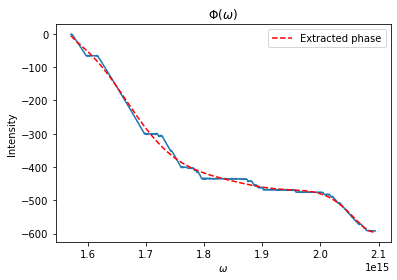

In [11]:
phase = sif.DeltaPhiRetrievalProcedure(x=omegas, y=intensity, order = 9, keep_min_freq = 0.025e-13, keep_max_freq = -1, side = "left", show_plots = True, fft_x_lim = [-1e-13, 1e-13], fft_y_lim=[-1, 10], hanning = False, normalise=False)[0]


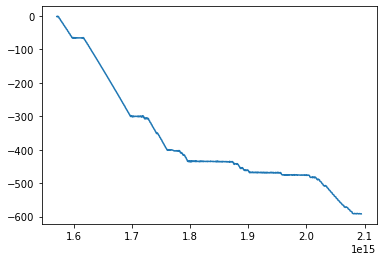

In [12]:
plt.plot(omegas,phase)
#plt.ylim([0,-10])
#plt.xlim([1.575e15, 1.58e15])

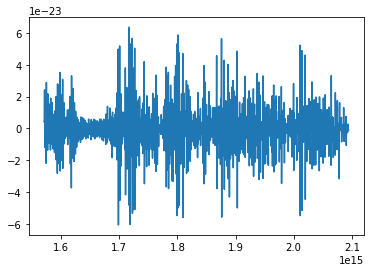

In [13]:
beta_2 = second_order_cda(omegas, phase / 0.575)
plt.plot(omegas,beta_2)
plt.show()
D = - omegas**2 / (2 * np.pi * 3e17) * beta_2

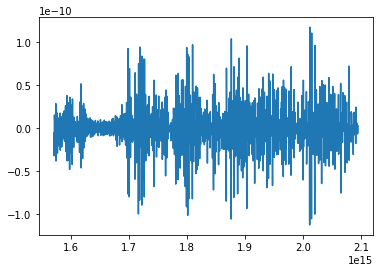

In [14]:
plt.plot(omegas, D)

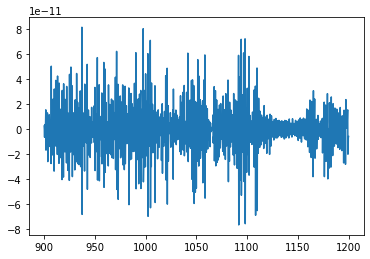

In [15]:
[wavelengthsconverted,D_wavelengths] = sifomega.ConvertOmegaSpectraToWavelength(omegas,D)
plt.plot(wavelengthsconverted,D_wavelengths)

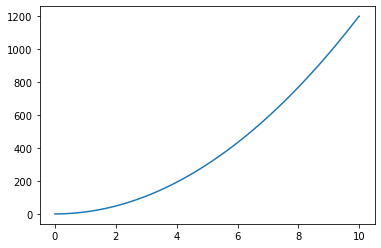

In [16]:
x = np.linspace(0,10,1000)
y = x**4
y_2der = second_order_cda(x, y)
plt.plot(x, y_2der)

# Rolling avg followed by CDA

In [17]:
def rolling_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

(1575000000000000.0, 1750000000000000.0)

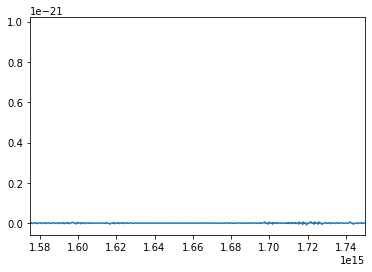

In [18]:
avg_data = rolling_average(phase, 5)
#plt.plot(omegas,avg_data)
avg_data2_der = second_order_cda(omegas, avg_data)
plt.plot(omegas, avg_data2_der)
plt.xlim([1.575e15,1.75e15])
#plt.ylim([0.0e-21,0.5e-21])